In [77]:
import sys
import logging
from uuid import UUID

import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt

logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

iphone_ids = [UUID("079e0f1a-c440-3d7c-b0e7-de160f748e35"), UUID("c76a0487-7e5a-3b17-a449-47be666b36f6"),
              UUID("c528bcd2-a88b-3e82-be62-ef4f2396967a"), UUID("95e70727-a04e-3e33-b7fe-34ab19194f8b")]
android_ids = [UUID("e471711e-bd14-3dbe-80b6-9c7d92ecc296"), UUID("fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7"),
               UUID("86842c35-da28-32ed-a90e-2da6663c5c73"), UUID("3bc0f91f-7660-34a2-b005-5c399598a369")]

In [78]:
list(edb.get_timeseries_db().find({"metadata.key": "config/sensor_config", "data.battery_status": {"$exists": True}}).sort("metadata.write_ts").limit(10))

[{u'_id': ObjectId('56fadecd88f66341cb3618c9'),
  u'data': {u'android_health': u'GOOD',
   u'android_plugged': u'USB',
   u'android_technology': u'Li-ion',
   u'android_temperature': 226,
   u'android_voltage': 226,
   u'battery_level_pct': 100,
   u'battery_status': 5},
  u'metadata': {u'key': u'config/sensor_config',
   u'platform': u'android',
   u'read_ts': 1459281599.629,
   u'time_zone': u'America/Los_Angeles',
   u'type': u'sensor-data',
   u'write_fmt_time': u'2016-03-29T11:56:24.694000-07:00',
   u'write_local_dt': datetime.datetime(2016, 3, 29, 11, 56, 24, 694000),
   u'write_ts': 1459277784.694},
  u'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')},
 {u'_id': ObjectId('56faecf288f66323bcc68ee9'),
  u'data': {u'android_health': u'GOOD',
   u'android_plugged': u'USB',
   u'android_technology': u'Li-ion',
   u'android_temperature': 197,
   u'android_voltage': 197,
   u'battery_level_pct': 100,
   u'battery_status': 2},
  u'metadata': {u'key': u'config/sensor_config',
   

In [79]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(u), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids)

#time query specification
dt1 = pydt.datetime(2016, 7, 21, 10, 0)
dt2 = pydt.datetime(2016, 7, 22, 11, 0)

ts1 = int(dt1.strftime("%s"))
ts2 = int(dt2.strftime("%s"))

time_range = estt.TimeQuery("metadata.write_ts", ts1, ts2)

#BuiltinTimeSeries.get_data_df(key, time_query = None, geo_query = None, extra_query_list=None) 
#type: list of DataFrame objects (regarding state info)
iphone_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), iphone_ts)
android_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), android_ts)

iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), iphone_ts)
android_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), android_ts)

In [80]:
iphone_test = iphone_battery_df_list[0]
iphone_test[['fmt_time', 'battery_level_pct', 'battery_status']]
#iphone_test
len(iphone_test)

41

In [81]:
android_battery_df_list[2].set_value(0, 'battery_level_pct', 100)
android_battery_df_list[2].set_value(0, 'battery_status', 1)

android_test = android_battery_df_list[2]
android_test[['fmt_time', 'battery_level_pct', 'battery_status']]

,fmt_time,battery_level_pct,battery_status
0,2016-07-21T10:55:16.368000-07:00,100,1
1,2016-07-21T12:00:44.200000-07:00,94,1
2,2016-07-21T13:02:52.419000-07:00,90,1
3,2016-07-21T14:57:43.449000-07:00,84,1
4,2016-07-21T19:06:26.364000-07:00,68,1
5,2016-07-22T01:13:08.853000-07:00,43,1
6,2016-07-22T07:18:25.989000-07:00,16,1


In [82]:
def get_ranges_df(battery_df, state_df):
    #the experiment runs until the battery drains completely
    #so start_ts should be the last time it was reported 100% battery level
    full_df = battery_df[battery_df.battery_level_pct == 100]
    if len(full_df) != 0:
        last_full_ts = full_df.iloc[-1].ts 
        start_ts = last_full_ts
    else: 
        start_ts = battery_df.iloc[0].ts
        
    charging_df = battery_df[battery_df.battery_status == 2]
    if len(charging_df) != 0:
        first_charging_ts = charging_df.iloc[0].ts
        end_ts = first_charging_ts
    else:
        end_ts = battery_df.iloc[-1].ts
    
    #find start_ts & end_ts for the period when battery_status=1=discharging
    #discharging_df = battery_df[battery_df.battery_status == 1]
    #discharging_df.reset_index(inplace=True)
    #start_ts = discharging_df.iloc[0].ts
    #end_ts = discharging_df.iloc[-1].ts
    
    ranges_df = pd.DataFrame({'start_ts': [start_ts], 'end_ts': [end_ts]})
    return ranges_df

In [83]:
def get_ranges_df_list(battery_df_list, state_df_list):
    ranges_df_list = []
    length = len(battery_df_list)
    for i in range(0, length):
        ranges_df_list.append(get_ranges_df(battery_df_list[i], state_df_list[i]))
    return ranges_df_list

In [84]:
iphone_ranges_df_list = get_ranges_df_list(iphone_battery_df_list, iphone_state_df_list)

#iphone_concat_ranges_df = pd.concat([iphone_ranges_df_list[0], iphone_ranges_df_list[1], iphone_ranges_df_list[2], iphone_ranges_df_list[3]])
#print iphone_concat_ranges_df

iphone_ranges_df = pd.DataFrame()
for df in iphone_ranges_df_list:
    iphone_ranges_df = iphone_ranges_df.append(df)

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)
iphone_ranges_df['start_dt'] = iphone_ranges_df.start_ts.apply(ts_to_dt)
iphone_ranges_df['end_dt'] = iphone_ranges_df.end_ts.apply(ts_to_dt)

iphone_ranges_df

,end_ts,start_ts,start_dt,end_dt
0,1.469131e+09,1.469139e+09,2016-07-21 15:09:55.474052,2016-07-21 13:00:05.877346
0,1.469131e+09,1.469196e+09,2016-07-22 07:00:26.006557,2016-07-21 13:00:05.678846
0,1.469131e+09,1.469139e+09,2016-07-21 15:10:04.115472,2016-07-21 13:00:05.319729
0,1.469131e+09,1.469198e+09,2016-07-22 07:35:27.400110,2016-07-21 13:00:09.643776


In [85]:
android_ranges_df_list = get_ranges_df_list(android_battery_df_list, android_state_df_list)

#android_concat_ranges_df = pd.concat([ranges_df_list[0], ranges_df_list[1], ranges_df_list[2], ranges_df_list[3]])
#android_concat_ranges_df

android_ranges_df = pd.DataFrame()
for df in android_ranges_df_list:
    android_ranges_df = android_ranges_df.append(df)
    
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)
android_ranges_df['start_dt'] = android_ranges_df.start_ts.apply(ts_to_dt)
android_ranges_df['end_dt'] = android_ranges_df.end_ts.apply(ts_to_dt)
    
android_ranges_df

,end_ts,start_ts,start_dt,end_dt
0,1.469196e+09,1.469125e+09,2016-07-21 11:11:55.444,2016-07-22 07:06:53.318
0,1.469175e+09,1.469124e+09,2016-07-21 10:56:32.460,2016-07-22 01:10:23.863
0,1.469197e+09,1.469124e+09,2016-07-21 10:55:16.368,2016-07-22 07:18:25.989
0,1.469197e+09,1.469124e+09,2016-07-21 11:03:08.704,2016-07-22 07:11:21.578


In [86]:
iphone_start_ts = iphone_ranges_df.start_ts.max() 
iphone_end_ts = iphone_ranges_df.end_ts.min() + 60*60
i_t1 = pydt.datetime.fromtimestamp(iphone_start_ts)
i_t2 = pydt.datetime.fromtimestamp(iphone_end_ts)
print 'iphone_start_ts=' + str(i_t1) + '\n' + 'iphone_end_ts=' + str(i_t2)
print  (iphone_end_ts-iphone_start_ts)/3600.0

iphone_start_ts=2016-07-22 07:35:27.400110
iphone_end_ts=2016-07-21 14:00:05.319729
-17.5894667725


In [87]:
android_start_ts = android_ranges_df.start_ts.max() 
android_end_ts = android_ranges_df.end_ts.max() 
a_t1 = pydt.datetime.fromtimestamp(android_start_ts)
a_t2 = pydt.datetime.fromtimestamp(android_end_ts)
print 'android_start_ts=' + str(a_t1) + '\n' + 'android_end_ts=' + str(a_t2)
print  (android_end_ts-android_start_ts)/3600.0

android_start_ts=2016-07-21 11:11:55.444000
android_end_ts=2016-07-22 07:18:25.989000
20.1084847222


In [88]:
import numpy as np

iphone_xnew = np.arange(iphone_start_ts, iphone_end_ts, 15 * 60) # 15 minutes
print len(iphone_xnew)

0


In [89]:
android_xnew = np.arange(android_start_ts, android_end_ts, 15 * 60) # 15 minutes
print type(android_xnew)

<type 'numpy.ndarray'>


In [90]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [91]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [92]:
iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, iphone_xnew), iphone_battery_df_list)


In [93]:
android_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), android_battery_df_list)

In [94]:
label = ['1hr', '1hr', '1hr', '1hr']
style = ['ob', 'og', 'or', 'oc']
title = "TrackingOn_Stationary_HAFS "

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

About to plot 0
About to plot 1
About to plot 2
About to plot 3


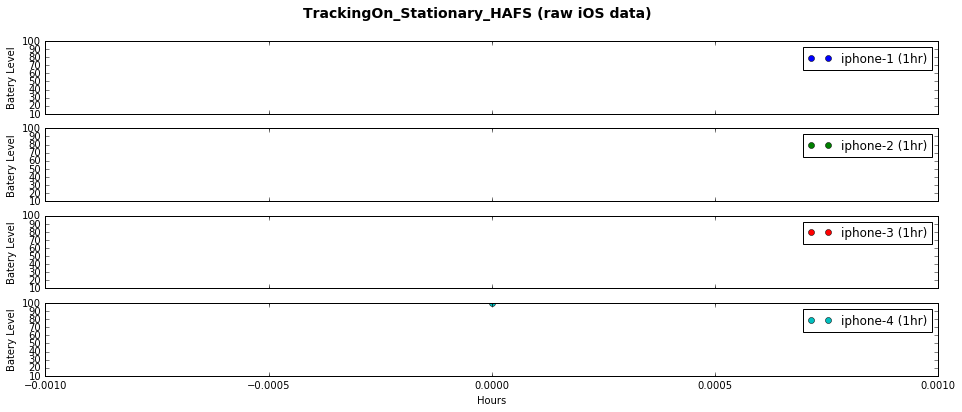

In [98]:
#iOS: No interplation on battery data
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle(title + '(raw iOS data)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-iphone_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=aaxes[i], label="iphone-%s (1hr)" % (i+1))
    aaxes[i].set_xlabel('Hours')
    aaxes[i].set_ylabel('Batery Level')
    aaxes[i].set_xlim(left=0)
    #plt.xticks(np.arange(0, max(df['hr'])+2, 2.0))
    
#afig.savefig('scatter_Apr_2-3_iOS.png')

About to plot 0


TypeError: Empty 'DataFrame': no numeric data to plot

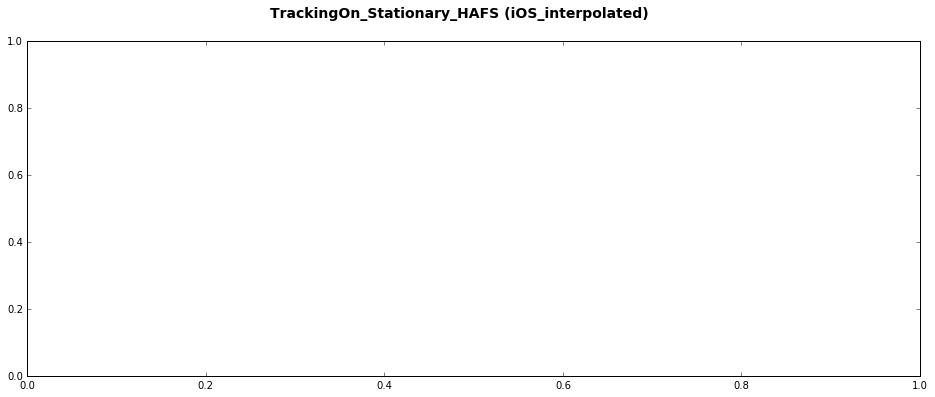

In [99]:
#iOS: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
ifig.suptitle(title + '(iOS_interpolated)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-iphone_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, 7), label="iphone-%s (1hr)" % (i+1))
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, max(df['hr']), 2.0))

#ifig.savefig('interp_Apr_2-3_iOS.png') 

In [ ]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
ifig.suptitle(title + '(iOS_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, 22), label="iphone-%s (1hr)" % (i+1), legend=True)

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes, xlim=(0, 22), legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, 22, 2.0))

    
#ifig.savefig('overlaid_Apr_2-3_iOS.png')  

In [ ]:
#iOS
#correlation analysis 
#generate list of iphone battery series 
iphone_battery_series_list = map(lambda b: b.battery_level_pct, iphone_battery_interp_df_list)
print np.corrcoef(iphone_battery_series_list)
plt.matshow(np.corrcoef(iphone_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()

In [ ]:
#Android: No interplation on battery data 
print len(android_battery_df_list)
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle(title + '(raw Android data)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    df['dt'] = df.ts.apply(ts_to_dt)
    df['hr'] = (df.ts-android_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=aaxes[i], label="android.%s (1hr)" % (i+1))
    aaxes[i].set_xlabel('Hours')
    aaxes[i].set_ylabel('Batery Level')
    aaxes[i].set_xlim(left=0)
    #plt.xticks(np.arange(0, max(df['hr'])+2, 1))
    
#afig.savefig('scatter_Apr_2-3_Android.png')

About to plot 0
About to plot 1
About to plot 2
About to plot 3


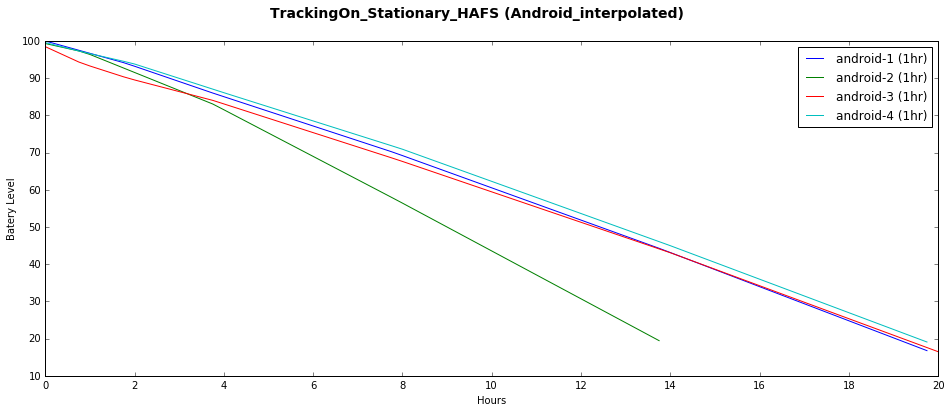

In [100]:
#Android: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle(title + '(Android_interpolated)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-android_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, 20), label="android-%s (1hr)" % (i+1))
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, 22, 2))
    
#ifig.savefig('interp_Apr_2-3_Android.png')    

About to plot 0
About to plot 1
About to plot 2
About to plot 3
About to plot 0


AttributeError: 'DataFrame' object has no attribute 'hr'

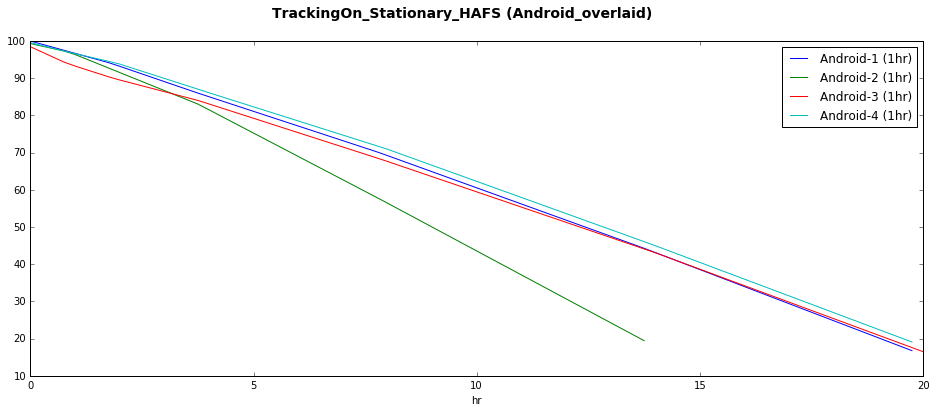

In [101]:
#Android: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle(title + '(Android_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', ax=iaxes, xlim=(0, max(df.hr)), label="Android-%s (1hr)" % (i+1), legend=True)


for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes, xlim=(0, max(df.hr)), legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    plt.xticks(np.arange(0, max(df['hr'])+1, 2))
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))
    
#ifig.savefig('overlaid_Apr_2-3_Android.png') 

[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan   1.  nan]
 [ nan  nan  nan  nan]]


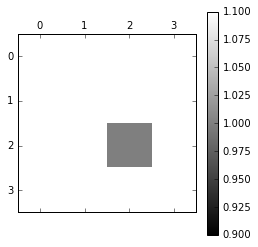

In [102]:
#Android 
#correlation analysis(tracking_off+stationary)
#generate list of android battery series 
android_battery_series_list = map(lambda b: b.battery_level_pct, android_battery_interp_df_list)
print np.corrcoef(android_battery_series_list)
plt.matshow(np.corrcoef(android_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()

In [103]:
l = [1,2]
len(l)

2

In [104]:
l.append(3)
l
len(l)

3

In [105]:
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(u), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids)

iphone_time_range = estt.TimeQuery("metadata.write_ts", iphone_start_ts, iphone_end_ts)
android_time_range = estt.TimeQuery("metadata.write_ts", android_start_ts, android_end_ts)

iphone_battery_df_discharge_list = map(lambda t:t.get_data_df("background/battery", iphone_time_range), iphone_ts)
android_battery_df_discharge_list = map(lambda t:t.get_data_df("background/battery", android_time_range), android_ts)

<class 'pandas.core.series.Series'>
[  1  -6  -8 -16 -26 -28]
5
5
   delta_b   delta_t     slope            ts                fmt_time   b
1       -6  1.807827 -3.318902  1.469131e+09 2016-07-21 13:00:23.621  94
2       -8  1.945834 -4.111348  1.469138e+09 2016-07-21 14:57:08.623  86
3      -16  4.061190 -3.939732  1.469153e+09 2016-07-21 19:00:48.908  70
4      -26  5.997490 -4.335147  1.469174e+09 2016-07-22 01:00:39.872  44
5      -28  6.103735 -4.587355  1.469196e+09 2016-07-22 07:06:53.318  16


/Users/yawen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


count    5.000000
mean    -4.058497
std      0.479616
min     -4.587355
25%     -4.335147
50%     -4.111348
75%     -3.939732
max     -3.318902
Name: slope, dtype: float64

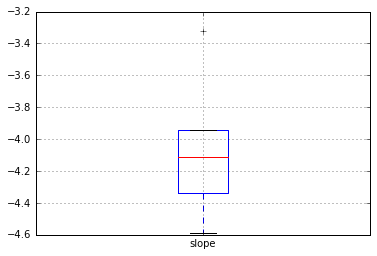

In [109]:
import numpy as np
itest = android_battery_df_discharge_list[0]
#print itest.battery_level_pct
print type(itest.battery_level_pct) #<class 'pandas.core.series.Series'>
b = itest.battery_level_pct
delta_b = np.diff(itest.battery_level_pct)
delta_b = np.insert(delta_b, 0, 1)
#print delta_b
ts = itest.metadata_write_ts

rate_df = pd.DataFrame({'delta_b':delta_b, 'ts':ts, 'b':b})
rate_df = rate_df[rate_df.delta_b!=0]
print delta_b
delta_b = rate_df.delta_b[1:]
delta_t = np.diff(rate_df.ts)/3600 #convert from seconds to hrs 
print len(delta_b)
print len(delta_t)
slope_df = pd.DataFrame({'delta_b':delta_b, 'delta_t':delta_t})
slope_df['slope'] = delta_b/delta_t
slope_df['ts'] = rate_df.ts[1:]
slope_df['fmt_time'] = slope_df.ts.apply(ts_to_dt)
slope_df['b'] = rate_df.b[1:]

#remove outliners 
slope_df = slope_df[slope_df.slope>-10 ]
slope_df = slope_df[slope_df.slope<-2 ]

print slope_df

#_, breaks=np.histogram(df.MAT,bins=1)
#(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
#iaxes = iaxes2d
ax = slope_df.boxplot(column='slope')
slope_df.slope.describe()